In [3]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from elasticsearch import Elasticsearch

ModuleNotFoundError: No module named 'elasticsearch'

<h1 align="center">Projeto Final de Spark </h1>
<h2 align="center">Campanha Nacional de Vacinação contra Covid-19</h2>
<br>

<b><h3> 1. Enviar os dados para o hdfs </h3></b>
<p> Antes de enviar os dados para o HDFS, foram executados os seguintes passos: </p><br>
<p> 1 - Fazer o download do arquivo pelo terminal, dentro da pasta input (caminho: /docker-bigdata/spark/input) <br><br>
    <li> sudo curl -O https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/04bd3419b22b9cc5c6efac2c6528100d_HIST_PAINEL_COVIDBR_06jul2021.rar </li>
</p>

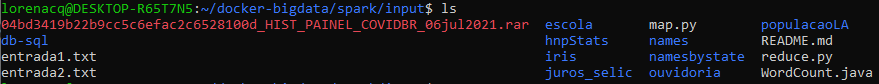

<br>
<p> 2 - Instalar unrar para descompactar o arquivo .rar: <br> <br>
    <li> sudo apt-get install unrar </li>
</p> <br>

<p> 3 - Descompactar o arquivo: <br> <br>
    <li> sudo unrar x 04bd3419b22b9cc5c6efac2c6528100d_HIST_PAINEL_COVIDBR_06jul2021.rar
       <br> Obs: na pasta input dentro do namenode já vão aparecer os arquivos, pois o caminho está configurado no arquivo "docker-compose-parcial.yml"
    </li>  
</p> 

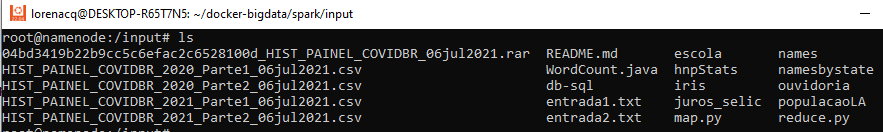

<p> 4 - Acessar o namenode: <br> <br>
    <li> docker exec -it namenode bash </li>
</p> <br>

<p> 5. Criar a pasta "projeto-final-spark" no HDFS e depois enviar todos os dados do diretório input para o HDFS em /user/lorena/projeto-final-spark: <br> <br>
    <li> hdfs dfs -mkdir -p /user/lorena/projeto-final-spark </li>
    <li> hdfs dfs -put /input/*.csv /user/lorena/projeto-final-spark </li>
    <li> <b> Verificar se os dados foram enviados corretamente: </b> hdfs dfs -ls /user/lorena/projeto-final-spark </li>
</p>

<b><h3> 2. Otimizar todos os dados do hdfs para uma tabela Hive particionada por município. </h3></b>
<br>
<b><p> Obs: Antes de fazer o particionamento, foram feitos alguns ajustes </p></b>

In [4]:
!hdfs dfs -ls /user/lorena/projeto-final-spark

Found 5 items
-rw-r--r--   3 root supergroup   62492959 2022-08-04 15:47 /user/lorena/projeto-final-spark/HIST_PAINEL_COVIDBR_2020_Parte1_06jul2021.csv
-rw-r--r--   3 root supergroup   76520681 2022-08-04 15:47 /user/lorena/projeto-final-spark/HIST_PAINEL_COVIDBR_2020_Parte2_06jul2021.csv
-rw-r--r--   3 root supergroup   91120916 2022-08-04 15:47 /user/lorena/projeto-final-spark/HIST_PAINEL_COVIDBR_2021_Parte1_06jul2021.csv
-rw-r--r--   3 root supergroup    3046774 2022-08-04 15:47 /user/lorena/projeto-final-spark/HIST_PAINEL_COVIDBR_2021_Parte2_06jul2021.csv
drwxr-xr-x   - root supergroup          0 2022-08-05 22:53 /user/lorena/projeto-final-spark/casos_confirmados_parquet


In [5]:
#Habilitando o inferSchema essa função passará pela entrada uma vez para determinar o esquema de entrada. Por padrão todos esses parâmetros abaixo vem desabilitados (false)
dados_covidbr = spark.read.csv("hdfs://namenode/user/lorena/projeto-final-spark/HIST_PAINEL_COVIDBR_202*.csv", 
                                   sep=";", #Define o caractere único como separador para cada campo e valor.
                                   header=True, #Usa a primeira linha como nomes de colunas.
                                   inferSchema=True, #Infere o esquema de entrada automaticamente a partir dos dados. Requer uma passagem extra sobre os dados.
                                   ignoreLeadingWhiteSpace=True, #Define se os espaços em branco iniciais dos valores que estão sendo lidos devem ou não ser ignorados.
                                   ignoreTrailingWhiteSpace=True) #Define se os espaços em branco à direita dos valores que estão sendo lidos devem ser ignorados.

In [4]:
#Visualizar o Schema
dados_covidbr.printSchema()

root
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- coduf: integer (nullable = true)
 |-- codmun: integer (nullable = true)
 |-- codRegiaoSaude: integer (nullable = true)
 |-- nomeRegiaoSaude: string (nullable = true)
 |-- data: timestamp (nullable = true)
 |-- semanaEpi: integer (nullable = true)
 |-- populacaoTCU2019: integer (nullable = true)
 |-- casosAcumulado: decimal(10,0) (nullable = true)
 |-- casosNovos: integer (nullable = true)
 |-- obitosAcumulado: integer (nullable = true)
 |-- obitosNovos: integer (nullable = true)
 |-- Recuperadosnovos: integer (nullable = true)
 |-- emAcompanhamentoNovos: integer (nullable = true)
 |-- interior/metropolitana: integer (nullable = true)



In [3]:
dados_covidbr.show(2, vertical=True)

-RECORD 0-------------------------------------
 regiao                 | Brasil              
 estado                 | null                
 municipio              | null                
 coduf                  | 76                  
 codmun                 | null                
 codRegiaoSaude         | null                
 nomeRegiaoSaude        | null                
 data                   | 2020-02-25 00:00:00 
 semanaEpi              | 9                   
 populacaoTCU2019       | 210147125           
 casosAcumulado         | 0                   
 casosNovos             | 0                   
 obitosAcumulado        | 0                   
 obitosNovos            | 0                   
 Recuperadosnovos       | null                
 emAcompanhamentoNovos  | null                
 interior/metropolitana | null                
-RECORD 1-------------------------------------
 regiao                 | Brasil              
 estado                 | null                
 municipio   

In [6]:
#Remover informação sobre hora, pois estão zeradas
dados_covidbr_otimizado = dados_covidbr\
.withColumn("data", from_unixtime(unix_timestamp(col("data")), "yyyy-MM-dd hh:mm"))

#Visualizando os dados com o campo data ajustado
dados_covidbr_otimizado.show(2, vertical=True) 

-RECORD 0----------------------------------
 regiao                 | Brasil           
 estado                 | null             
 municipio              | null             
 coduf                  | 76               
 codmun                 | null             
 codRegiaoSaude         | null             
 nomeRegiaoSaude        | null             
 data                   | 2020-02-25 12:00 
 semanaEpi              | 9                
 populacaoTCU2019       | 210147125        
 casosAcumulado         | 0                
 casosNovos             | 0                
 obitosAcumulado        | 0                
 obitosNovos            | 0                
 Recuperadosnovos       | null             
 emAcompanhamentoNovos  | null             
 interior/metropolitana | null             
-RECORD 1----------------------------------
 regiao                 | Brasil           
 estado                 | null             
 municipio              | null             
 coduf                  | 76    

<h4>Particionando por Município</h4>

In [ ]:
#Particionar por município (tive que rodar pelo terminal no spark-shell, por aqui estava travando)
dados_covidbr_hive = dados_covidbr_otimizado.write.partitionBy("municipio").saveAsTable("covidbr")

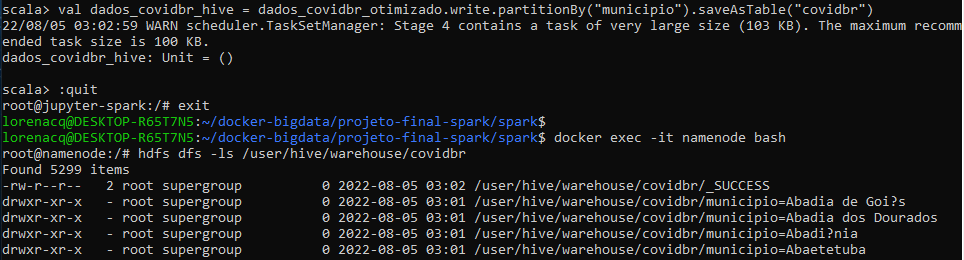

In [5]:
#Verificar se os dados foram gerados
!hdfs dfs -ls "hdfs://namenode:8020/user/hive/warehouse/covidbr/"

Found 5299 items
-rw-r--r--   2 root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/_SUCCESS
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Abadia de Goiás
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Abadia dos Dourados
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Abadiânia
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Abaetetuba
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Abaeté
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Abaiara
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/h

drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Barracão
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Barras
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Barreira
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Barreiras
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Barreiras do Piauí
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Barreirinha
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Barreirinhas
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/wareh

drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Conceição do Canindé
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Conceição do Castelo
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Conceição do Coité
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Conceição do Jacuípe
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Conceição do Lago-Açu
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Conceição do Mato Dentro
drwxr-xr-x   - root supergroup          0 2022-08-05 20:20 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Conceição do Pará
drwxr-xr-x   - root supergr

drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=João Dias
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=João Dourado
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=João Lisboa
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=João Monlevade
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=João Neiva
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=João Pessoa
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=João Pinheiro
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hi

drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Pedro Osório
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Pedro Régis
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Pedro Teixeira
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Pedro Velho
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Pedro de Toledo
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Pedro do Rosário
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Pedrão
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/us

drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Vicentina
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Vicentinópolis
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Victor Graeff
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Vicência
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Vidal Ramos
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Videira
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehouse/covidbr/municipio=Vieiras
drwxr-xr-x   - root supergroup          0 2022-08-05 20:21 hdfs://namenode:8020/user/hive/warehous

<b><h3> 3. Criar as 3 vizualizações pelo Spark com os dados enviados para o HDFS: </h3></b>
<br>

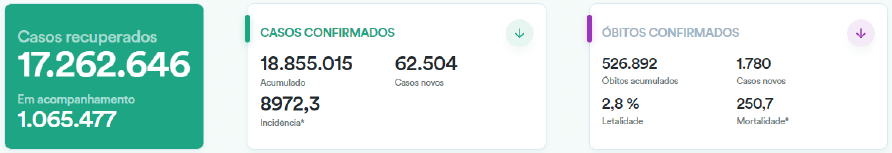

In [7]:
painel_covid_hdfs = spark.read.table("covidbr")

In [8]:
painel_covid_hdfs.printSchema()

root
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- coduf: integer (nullable = true)
 |-- codmun: integer (nullable = true)
 |-- codRegiaoSaude: integer (nullable = true)
 |-- nomeRegiaoSaude: string (nullable = true)
 |-- data: string (nullable = true)
 |-- semanaEpi: integer (nullable = true)
 |-- populacaoTCU2019: integer (nullable = true)
 |-- casosAcumulado: decimal(10,0) (nullable = true)
 |-- casosNovos: integer (nullable = true)
 |-- obitosAcumulado: integer (nullable = true)
 |-- obitosNovos: integer (nullable = true)
 |-- Recuperadosnovos: integer (nullable = true)
 |-- emAcompanhamentoNovos: integer (nullable = true)
 |-- interior/metropolitana: integer (nullable = true)
 |-- municipio: string (nullable = true)



<h3 style="color: green;"> Visualização 1 - Casos Recuperados e Em Acompanhamento</h3>

In [9]:
casos_recuperados_acompanhamento = painel_covid_hdfs.select(translate(format_number(col("Recuperadosnovos") ,0),",.",".,").alias("Casos_Recuperados"), \
                                         translate(format_number(col("emAcompanhamentoNovos") ,0),",.",".,").alias("Em_Acompanhamento")) \
                                         .sort(desc("data")) \
                                         .limit(1) 

In [10]:
casos_recuperados_acompanhamento.show()

+-----------------+-----------------+
|Casos_Recuperados|Em_Acompanhamento|
+-----------------+-----------------+
|       17.262.646|        1.065.477|
+-----------------+-----------------+



<h3 style="color: green;"> Visualização 2 - Casos Confirmados</h3>

In [10]:
casos_confirmados = painel_covid_hdfs.select(translate(format_number(col("casosAcumulado") ,0),",.",".,").alias("Acumulado"), \
                                                   col("casosNovos").alias("Casos_novos"), \
                                                   format_number(((col("casosAcumulado") * lit(100000)) / col("populacaoTCU2019")),1).alias("Incidencia")) \
                                         .sort(desc("data")) \
                                         .limit(1)

In [12]:
casos_confirmados.show()

+----------+-----------+----------+
| Acumulado|Casos_novos|Incidencia|
+----------+-----------+----------+
|18.855.015|      62504|   8,972.3|
+----------+-----------+----------+



<h3 style="color: purple;"> Visualização 3 - Óbitos Confirmados</h3>

In [11]:
covid_obito = painel_covid_hdfs.select(col("obitosAcumulado").alias("Obitos_acumulados"), \
                                         col("obitosNovos").alias("Obitos_novos"), \
                                         format_number(((col("obitosAcumulado") * lit(100)) / col("casosAcumulado")),1).alias("Letalidade"), \
                                         format_number(((col("obitosAcumulado") * lit(1000)) / col("populacaoTCU2019")),1).alias("Mortalidade")) \
                                         .sort(desc("data")) \
                                         .limit(1)

In [14]:
covid_obito.show()

+-----------------+------------+----------+-----------+
|Obitos_acumulados|Obitos_novos|Letalidade|Mortalidade|
+-----------------+------------+----------+-----------+
|           526892|        1780|       2.8|        2.5|
+-----------------+------------+----------+-----------+



<b><h3> 4. Salvar a primeira visualização como tabela Hive </h3></b>
<br>

In [17]:
#Salvar tabela
casos_recuperados_acompanhamento.write.saveAsTable("casos_rec_aco")

<b><h3> 5. Salvar a segunda visualização com formato parquet e compressão snappy </h3></b>
<br>

In [18]:
#Salvar compressão anappy e formato parquet
casos_confirmados.write.option("compression", "snappy").parquet("/user/lorena/projeto-final-spark/casos_confirmados_parquet")

<b><h3> 6. Salvar a terceira visualização em um tópico no Kafka </h3></b>
<br>

In [19]:
covid_obito.select(col("Obitos_acumulados").cast("string").alias("value")).write \
           .format("kafka") \
           .option("kafka.bootstrap.servers", "kafka:9092") \
           .option("topic", "topic-covid") \
           .save()

<b><h3> 7. Criar a visualização pelo Spark com os dados enviados para o HDFS: </h3></b>
<br>

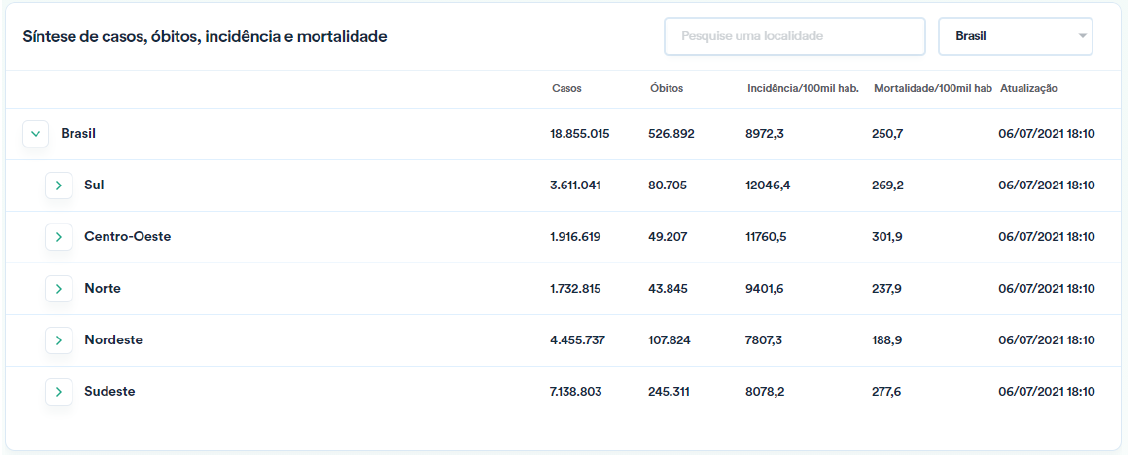

<h4> Primeiro fazer a organização dos dados para depois juntar</h4>

In [12]:
#Organizar os dados por estado
covid_estado = painel_covid_hdfs.select(col("estado"),struct(col("regiao"), \
                                            col("municipio"),col("data"), \
                                            col("populacaoTCU2019"),col("casosAcumulado"), \
                                            col("obitosAcumulado")).alias("ob")) \
                                    .where(col("ob.municipio").isNull()) \
                                    .groupBy(col("estado")) \
                                    .agg(max(col("ob")).alias("dados"))

covid_estado.show(truncate=False) #Exibe os dados na tabela

+------+---------------------------------------------------------+
|estado|dados                                                    |
+------+---------------------------------------------------------+
|SC    |[Sul,, 2021-07-06 12:00, 7164788, 1066484, 17146]        |
|RO    |[Norte,, 2021-07-06 12:00, 1777225, 251977, 6226]        |
|PI    |[Nordeste,, 2021-07-06 12:00, 3273227, 299084, 6662]     |
|AM    |[Norte,, 2021-07-06 12:00, 4144597, 405066, 13349]       |
|RR    |[Norte,, 2021-07-06 12:00, 605761, 113758, 1763]         |
|GO    |[Centro-Oeste,, 2021-07-06 12:00, 7018354, 686433, 19485]|
|null  |[Brasil,, 2021-07-06 12:00, 210147125, 18855015, 526892] |
|TO    |[Norte,, 2021-07-06 12:00, 1572866, 200243, 3266]        |
|MT    |[Centro-Oeste,, 2021-07-06 12:00, 3484466, 456155, 12000]|
|SP    |[Sudeste,, 2021-07-06 12:00, 45919049, 3809222, 130389]  |
|ES    |[Sudeste,, 2021-07-06 12:00, 4018650, 523115, 11582]     |
|PB    |[Nordeste,, 2021-07-06 12:00, 4018127, 402175, 8724]  

In [13]:
#Organizar os dados por Região
covid_regiao = covid_estado.groupBy(col("dados.regiao").alias("Regiao")).agg( \
                                        sum(col("dados.casosAcumulado")).alias("Casos"), \
                                        sum(col("dados.obitosAcumulado")).alias("Obitos"), \
                                        sum(col("dados.populacaoTCU2019")).alias("Populacao"), \
                                        max(col("dados.data")).alias("Data")) \
                               .sort(col("regiao"))

covid_regiao.show() #Exibe os dados na tabela

+------------+--------+------+---------+----------------+
|      Regiao|   Casos|Obitos|Populacao|            Data|
+------------+--------+------+---------+----------------+
|      Brasil|18855015|526892|210147125|2021-07-06 12:00|
|Centro-Oeste| 1916619| 49207| 16297074|2021-07-06 12:00|
|    Nordeste| 4455737|107824| 57071654|2021-07-06 12:00|
|       Norte| 1732815| 43845| 18430980|2021-07-06 12:00|
|     Sudeste| 7138803|245311| 88371433|2021-07-06 12:00|
|         Sul| 3611041| 80705| 29975984|2021-07-06 12:00|
+------------+--------+------+---------+----------------+



<h3 style="color: blue"> Visualização pelo Spark com os dados enviados para o HDFS (Final questão 7) </h3>

In [14]:
spark_visualizacao = covid_regiao.select(col("regiao").alias("Regiao"), \
                                                    translate(format_number(col("casos") ,0),",.",".,").alias("Casos"), \
                                                    col("obitos").alias("Obitos"), \
                                                    translate(format_number(((col("casos") / col("populacao")) * lit(100000)),1),",.",".,").alias("Incidencia"), \
                                                    translate(format_number(((col("obitos") / col("populacao")) * lit(100000)),1),",.",".,").alias("Mortalidade"), \
                                                    col("data").alias("Atualizacao"))

spark_visualizacao.show()

+------------+----------+------+----------+-----------+----------------+
|      Regiao|     Casos|Obitos|Incidencia|Mortalidade|     Atualizacao|
+------------+----------+------+----------+-----------+----------------+
|      Brasil|18.855.015|526892|   8.972,3|      250,7|2021-07-06 12:00|
|Centro-Oeste| 1.916.619| 49207|  11.760,5|      301,9|2021-07-06 12:00|
|    Nordeste| 4.455.737|107824|   7.807,3|      188,9|2021-07-06 12:00|
|       Norte| 1.732.815| 43845|   9.401,6|      237,9|2021-07-06 12:00|
|     Sudeste| 7.138.803|245311|   8.078,2|      277,6|2021-07-06 12:00|
|         Sul| 3.611.041| 80705|  12.046,4|      269,2|2021-07-06 12:00|
+------------+----------+------+----------+-----------+----------------+



<h3> 8. Salvar a visualização do exercício 6 em um tópico no Elastic </h3>

In [21]:
URL = "https://<my>.elastic-cloud.com"

In [24]:
covid_obito.write.format("org.elasticsearch.spark.sql") \
                .option("es.nodes", URL) \
                .option("es.port", '9200')\
                .option("es.resource", 'br_dashboard/sample') \
                .mode('overwrite')\
                .save()

Py4JJavaError: An error occurred while calling o400.save.
: org.elasticsearch.hadoop.EsHadoopIllegalArgumentException: Cannot resolve ip for hostname: <my>.elastic-cloud.com
	at org.elasticsearch.hadoop.util.SettingsUtils.resolveHostToIpIfNecessary(SettingsUtils.java:84)
	at org.elasticsearch.hadoop.util.SettingsUtils.qualifyNodes(SettingsUtils.java:46)
	at org.elasticsearch.hadoop.util.SettingsUtils.declaredNodes(SettingsUtils.java:142)
	at org.elasticsearch.hadoop.util.SettingsUtils.discoveredOrDeclaredNodes(SettingsUtils.java:148)
	at org.elasticsearch.hadoop.rest.NetworkClient.<init>(NetworkClient.java:64)
	at org.elasticsearch.hadoop.rest.NetworkClient.<init>(NetworkClient.java:58)
	at org.elasticsearch.hadoop.rest.RestClient.<init>(RestClient.java:101)
	at org.elasticsearch.hadoop.rest.InitializationUtils.discoverClusterInfo(InitializationUtils.java:335)
	at org.elasticsearch.spark.sql.ElasticsearchRelation.cfg$lzycompute(DefaultSource.scala:225)
	at org.elasticsearch.spark.sql.ElasticsearchRelation.cfg(DefaultSource.scala:223)
	at org.elasticsearch.spark.sql.ElasticsearchRelation.insert(DefaultSource.scala:603)
	at org.elasticsearch.spark.sql.DefaultSource.createRelation(DefaultSource.scala:108)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:45)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:70)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:68)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.doExecute(commands.scala:86)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:80)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:80)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:668)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:668)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:668)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:276)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:270)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


<h3> Referências </h3>

APACHE, SPARK. <b> Class DataFrameReader </b>, 2022. Disponível em : <https://spark.apache.org/docs/2.0.2/api/java/org/apache/spark/sql/DataFrameReader.html>. Acesso em: 03 ago. 2022.

BRASIL, CORONAVÍRUS. <b> Painel Coronavírus </b>, 2022. Disponível em : <https://covid.saude.gov.br>. Acesso em: 03 ago. 2022.

SPARKBYEXAMPLES. <b> Spark Read CSV file into DataFrame </b>, 2022. Disponível em: < https://sparkbyexamples.com/spark/spark-read-csv-file-into-dataframe/ >. Acesso em: 04 ago. 2022.